<a href="https://colab.research.google.com/github/akinyeleolat/pyspark_bid_data_analysis/blob/main/TrySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Update system packages
!sudo apt-get update

#install Java
!sudo apt install default-jdk

# Download Apache Spark and extract
!wget https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xvf spark-3.0.3-bin-hadoop2.7.tgz

#Install pyspark
!pip install -q findspark
!pip install pyspark
!pip install handyspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:15 http://ppa

# Analysis

In [2]:
#setting the environment path 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
os.environ["PYTHONPATH"] = "%SPARK_HOME%\python;%SPARK_HOME%\python\lib\py4j-0.10.9.2-src.zip:%PYTHONPATH%"
# findspark will locate spark in the system
import findspark
findspark.init()

In [3]:
#Running a local SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Big Data analytic assignment").getOrCreate()

In [ ]:
spark

In [ ]:
spark.sparkContext

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd
!ls

/content
drive  sample_data  spark-3.0.3-bin-hadoop2.7  spark-3.0.3-bin-hadoop2.7.tgz


In [5]:
#Replace part of string with another string
from pyspark.sql.functions import *
# from pyspark.sql.functions import regexp_replace

#spark data
spark_data = spark.read.format('csv').options(header='true', inferSchema='true').load("/content/drive/MyDrive/uel_dataset/UNSW-NB15.csv").toDF(
    'srcip','sport','dstip','dsport','proto','state','dur','sbytes','dbytes','sttl','dttl','sloss','dloss',
    'service','Sload','dload','Spkts','Dpkts','swin','dwin','stcpb','dtcpb','smeansz','dmeansz','trans_depth','res_bdy_len','Sjit','Djit','Stime','Ltime',
    'Sintpkt','Dintpkt','tcprtt','synack','ackdat','is_sm_ips_ports','ct_state_ttl','ct_flw_http_mthd','is_ftp_login','ct_ftp_cmd','ct_srv_src','ct_srv_dst','ct_dst_ltm',
    'ct_src_ltm','ct_src_dport_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','attack_cat','Label')
spark_data=spark_data.na.fill('Normal',['attack_cat'])
spark_data=spark_data.withColumn('attack_cat', regexp_replace('attack_cat', 'Backdoors', 'Backdoor'))
spark_data=spark_data.withColumn('attack_category', trim(spark_data.attack_cat))
spark_data.show(10, truncate=False)
spark_data.printSchema()

+----------+-----+-------------+------+-----+-----+------------+------+------+----+----+-----+-----+--------+---------+---------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+---------+---------+----------+----------+------------+------------+------------+------------+------------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+---------------+
|srcip     |sport|dstip        |dsport|proto|state|dur         |sbytes|dbytes|sttl|dttl|sloss|dloss|service |Sload    |dload    |Spkts|Dpkts|swin|dwin|stcpb     |dtcpb     |smeansz|dmeansz|trans_depth|res_bdy_len|Sjit     |Djit     |Stime     |Ltime     |Sintpkt     |Dintpkt     |tcprtt      |synack      |ackdat      |is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|

In [ ]:
spark_data.count()

2539738

In [6]:
from pyspark.sql.functions import col
spark_data.groupBy("attack_category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+---------------+-------+
|attack_category|  count|
+---------------+-------+
|         Normal|2218455|
|        Generic| 215481|
|       Exploits|  44525|
|        Fuzzers|  24246|
|            DoS|  16353|
| Reconnaissance|  13987|
|       Analysis|   2677|
|       Backdoor|   2329|
|      Shellcode|   1511|
|          Worms|    174|
+---------------+-------+



In [7]:
#Summary statics
numeric_features = [t[0] for t in spark_data.dtypes if t[1] == 'int' or t[1] == 'long'or t[1] == 'double']
num_data_set=spark_data.select(numeric_features)
num_data_set.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
sport,2539738,30536.92077804876,20441.2142160254,0,65535
dsport,2539738,11235.101156103503,18438.20315203261,0,65535
dur,2539738,0.6588633347840528,13.92577037447336,0.0,8786.6377
sbytes,2539738,4340.070896289302,56409.409186153316,0,14355774
dbytes,2539738,36432.01927679154,161105.33522674238,0,14657531
sttl,2539738,62.78151053376372,74.6267115956767,0,255
dttl,2539738,30.770441675479912,42.851930611408726,0,254
sloss,2539738,5.164537444413558,22.5183674285243,0,5319
dloss,2539738,16.331417650167065,56.597900641709714,0,5507


In [8]:
#correlation using vector assembler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *

#select only numeric column
numeric_features = [t[0] for t in spark_data.dtypes if t[1] == 'int' or t[1] == 'long'or t[1] == 'double']
num_data_set=spark_data.select(numeric_features)

assembler = VectorAssembler(inputCols=num_data_set.columns, 
outputCol="features",handleInvalid='keep')


df = assembler.transform(spark_data).select("features")

# correlation will be in Dense Matrix
correlation_matrix = Correlation.corr(df,"features","pearson").collect()[0][0]

# To convert Dense Matrix into DataFrame
rows = correlation_matrix.toArray().tolist()
df = spark.createDataFrame(rows,num_data_set.columns)
df.show(50,truncate=False)


+---------------------+---------------------+----------------------+----------------------+---------------------+---------------------+----------------------+---------------------+----------------------+---------------------+----------------------+---------------------+---------------------+--------------------+---------------------+----------------------+---------------------+----------------------+----------------------+----------------------+---------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|sport                |dsport               |dur                   |sbytes   

+-----+------+------------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+-------+-------+-----------+-----------+----------+---------+----------+----------+------------+------------+------------+------------+------------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+-----+
|sport|dsport|         dur|sbytes|dbytes|sttl|dttl|sloss|dloss|    Sload|    dload|Spkts|Dpkts|swin|dwin|smeansz|dmeansz|trans_depth|res_bdy_len|      Sjit|     Djit|     Stime|     Ltime|     Sintpkt|     Dintpkt|      tcprtt|      synack|      ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|Label|
+-----+------+------------+------+------+----+----+-----+-----+---------+---------+-----+-----+----+----+-------+-------+-----------+-----------+---------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff13a973d0>,
      dtype=object)

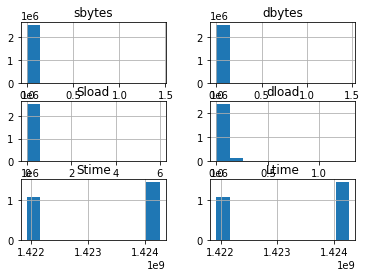

In [ ]:
#Kernel Density Estimation

#Get Random Data
numeric_features = [t[0] for t in spark_data.dtypes if t[1] == 'int' or t[1] == 'long'or t[1] == 'double']
num_data_set=spark_data.select(numeric_features)

data_set=num_data_set.sample(False, 0.1, seed=0)

data_set.count()

rdd_data = num_data_set.rdd

rdd_data.toDF().show()

# Find density estimates for the given values

rdd_data.toDF().select('sbytes','dbytes','Sload','dload','Stime','Ltime').toPandas().hist()

# rdd_data.toDF().alias("a").select("a.*").toPandas().hist()


# kd = KernelDensity()
# kd.setSample(rdd_data)
# kd.setBandwidth(3.0)


# densities = kd.estimate([])

In [9]:
# Hypothesis Testing
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.functions import *

#select only numeric column
numeric_features = [t[0] for t in spark_data.dtypes if t[1] == 'int' or t[1] == 'long'or t[1] == 'double']
num_data_set=spark_data.select(numeric_features)

assembler = VectorAssembler(inputCols=num_data_set.columns, 
outputCol="features",handleInvalid='keep')


df = assembler.transform(spark_data).select("features","Label").sample(False, 0.01, seed=0)

r = ChiSquareTest.test(df, "features","Label").head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

pValues: [1.0,0.9999998645535961,0.00012607118617868895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.585909181756051e-11,0.0,1.0,1.0,0.024251798065198837,0.0441599060586938,1.0,0.9999999999999744,0.0,0.0,0.0,0.02010867207639011,0.0,1.9044145038726867e-08,3.139999371626345e-11,5.837936833952284e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
degreesOfFreedom: [17574, 6954, 15609, 1421, 1623, 11, 7, 78, 189, 17183, 16779, 284, 269, 1, 1, 422, 746, 2, 118, 15355, 16107, 21373, 21386, 15740, 15534, 1967, 1770, 1415, 1, 4, 12, 1, 6, 62, 62, 58, 58, 58, 48, 63, 1]
statistics: [14219.378167552431,6364.3849862895195,16263.963060912612,24323.27577051027,13103.54039444562,22348.384034370087,12515.19876221397,3564.674720780881,3642.2432231271373,25271.801743596483,14307.786546894522,5170.956796308868,10136.883552838159,2553.816931205907,2537.8413952139645,19081.580132376326,11918.99049297446,49.734552545151665,856.2763447656342,8318.752363938676,8606.280273256725,21782.830252263513,21739.744847

In [10]:
#Binomial data prepration
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoder
stages = []
categoricalColumns = ['attack_category']

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )

# stage 1
stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Label', outputCol = 'label')
categ_stringIdx = StringIndexer(inputCol='attack_category', outputCol='catLabel')
# stage 2
stages += [label_stringIdx,categ_stringIdx]

numericCols = ['dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss',
               'Sload', 'dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'smeansz', 'dmeansz', 'trans_depth',
               'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
               'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
               'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
               'ct_dst_sport_ltm', 'ct_dst_src_ltm']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

print(assemblerInputs)

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
# stage 2
stages += [assembler]
# data_pyspark2=spark_data
# data_pyspark2.printSchema()
print(stages)

['attack_categoryclassVec', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']
[StringIndexer_8ac842761de2, OneHotEncoder_456e251357f1, StringIndexer_a84a1ebef13a, StringIndexer_07a8b81c8760, VectorAssembler_045db8cfd29f]


In [15]:
from pyspark.ml import Pipeline

Binomialdata = spark_data

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(Binomialdata)
Binomialdata = pipelineModel.transform(Binomialdata)
selectedCols = ['attack_category', 'features','label']
data_pyspark3 = Binomialdata.select(selectedCols)
data_pyspark3.printSchema()

root
 |-- attack_category: string (nullable = false)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [16]:
#Data training and testing
trainset, testset = data_pyspark3.randomSplit([0.7, 0.3], seed = 2021)
print("Training Dataset Count: " + str(trainset.count()))
print("Test Dataset Count: " + str(testset.count()))

Training Dataset Count: 1777507
Test Dataset Count: 762231


In [17]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(trainset)


In [ ]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))
print("Summary: "+ str(lrModel.summary.accuracy))
print("AreaUnderROC: "+ str(lrModel.summary.areaUnderROC))
print("FalsePositive: "+str(lrModel.summary.falsePositiveRateByLabel))
print("TruePositiveRate: "+str(lrModel.summary.truePositiveRateByLabel))

# We can also use the multinomial family for binary classification
# mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# # Fit the model
# mlrModel = mlr.fit(training)

# # Print the coefficients and intercepts for logistic regression with multinomial family
# print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
# print("Multinomial intercepts: " + str(mlrModel.interceptVector))

Coefficients: [-1.409669514560993,1.3447919814611775,1.252492873132705,1.2400003805255735,1.2385976957390779,1.2366216304085604,1.2331032772036206,1.2319519211700876,1.2314851033512977,1.2314984525416142,1.2312811714917595,1.230917283416855,1.2307605706872649,-5.5030659910054065e-06,6.567355173329582e-05,8.881047484635294e-08,-2.2049908228190599e-07,0.005673056222687562,0.0014583225938561222,-0.0009473333241336409,-0.0007967621765643826,7.572927432961397e-10,-2.436053332049977e-08,-0.0007563607872110511,-0.00044877019954735626,-0.0011780379127343328,-0.001173080493765644,-0.00020263726147727967,-0.00038022223853308716,-0.050229847727867656,-2.6768980259822555e-07,5.526353458623824e-07,-7.611394236838304e-06,-1.2518077561423313e-09,-1.2518123612593322e-09,-3.226995332861935e-06,-3.596998263547141e-06,1.4637655977280104,2.2541373631806323,2.8408700892914958,-0.1785453531442562,0.5996088918587519,-0.021892061101590754,-0.11166072454080102,-0.07548612574769278,0.01656719064957256,0.0167373

In [32]:
#Fitting testdata
lrFinal=lrModel.transform(testset)

In [33]:
#predictions
lrFinal.select('prediction','probability').show(20, truncate=False)

+----------+------------------------------------------+
|prediction|probability                               |
+----------+------------------------------------------+
|0.0       |[0.9989796873655007,0.0010203126344993777]|
|0.0       |[0.9991758082537245,8.241917462753871E-4] |
|0.0       |[0.9992446673128375,7.553326871625605E-4] |
|0.0       |[0.9990475424974752,9.524575025247432E-4] |
|0.0       |[0.9994321371474317,5.678628525683796E-4] |
|0.0       |[0.9993037633214704,6.962366785295187E-4] |
|0.0       |[0.9990324149758935,9.67585024106487E-4]  |
|0.0       |[0.9998422177556384,1.5778224436147878E-4]|
|0.0       |[0.9991707012106088,8.292987893912889E-4] |
|0.0       |[0.998640632183376,0.0013593678166240976] |
|0.0       |[0.9996959983256256,3.040016743742697E-4] |
|0.0       |[0.9994214251629485,5.785748370515403E-4] |
|0.0       |[0.9994214251629485,5.785748370515403E-4] |
|0.0       |[0.999699176884153,3.0082311584705626E-4] |
|0.0       |[0.9986392520127688,0.00136074798723

In [34]:
predictions=lrFinal
predictions.show()

+--------+---------------+--------------------+--------------------+--------------------+----------+
|catLabel|attack_category|            features|       rawPrediction|         probability|prediction|
+--------+---------------+--------------------+--------------------+--------------------+----------+
|     0.0|         Normal|(48,[0,9,10,11,12...|[6.88662536072991...|[0.99897968736550...|       0.0|
|     0.0|         Normal|(48,[0,9,10,11,12...|[7.10028282175611...|[0.99917580825372...|       0.0|
|     0.0|         Normal|(48,[0,9,10,11,12...|[7.18759664242780...|[0.99924466731283...|       0.0|
|     0.0|         Normal|(48,[0,9,10,11,12...|[6.95551215735230...|[0.99904754249747...|       0.0|
|     0.0|         Normal|(48,[0,9,10,11,12...|[7.47306260099656...|[0.99943213714743...|       0.0|
|     0.0|         Normal|(48,[0,9,10,11,12...|[7.26912442091322...|[0.99930376332147...|       0.0|
|     0.0|         Normal|(48,[0,9,10,11,12...|[6.93973920327148...|[0.99903241497589...|  

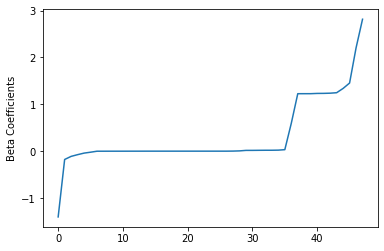

In [23]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

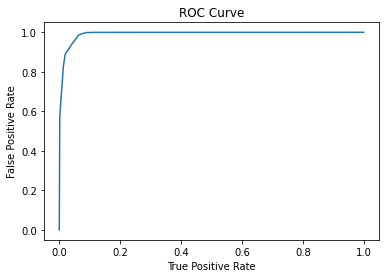

Training set areaUnderROC: 0.991198770327577


In [24]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

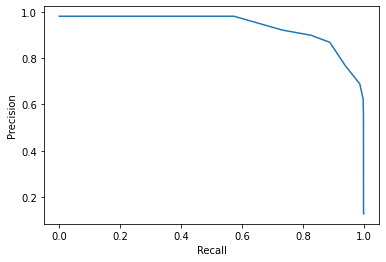

In [25]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9916647518679098


In [28]:
#Multiclass Binary classifier
from pyspark.ml import Pipeline

Binomialdata = spark_data

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(Binomialdata)
Binomialdata = pipelineModel.transform(Binomialdata)
selectedCols = ['catLabel','attack_category', 'features']
data_pyspark5 = Binomialdata.select(selectedCols)
data_pyspark5.printSchema()

root
 |-- catLabel: double (nullable = false)
 |-- attack_category: string (nullable = false)
 |-- features: vector (nullable = true)



In [29]:
#Data training and testing
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import *
import pyspark.sql.functions as F

trainset, testset = data_pyspark5.randomSplit([0.7, 0.3], seed = 2021)
print("Training Dataset Count: " + str(trainset.count()))
print("Test Dataset Count: " + str(testset.count()))

Training Dataset Count: 1777507
Test Dataset Count: 762231


In [36]:
from pyspark.sql.functions import col
testset.groupBy("attack_category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+---------------+------+
|attack_category| count|
+---------------+------+
|         Normal|665702|
|        Generic| 64505|
|       Exploits| 13479|
|        Fuzzers|  7225|
|            DoS|  4966|
| Reconnaissance|  4303|
|       Analysis|   821|
|       Backdoor|   712|
|      Shellcode|   460|
|          Worms|    58|
+---------------+------+



In [49]:
from pyspark.sql.functions import col
trainset.groupBy("attack_category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+---------------+-------+
|attack_category|  count|
+---------------+-------+
|         Normal|1552753|
|        Generic| 150976|
|       Exploits|  31046|
|        Fuzzers|  17021|
|            DoS|  11387|
| Reconnaissance|   9684|
|       Analysis|   1856|
|       Backdoor|   1617|
|      Shellcode|   1051|
|          Worms|    116|
+---------------+-------+



In [30]:
from pyspark.ml.classification import LogisticRegression
mlr = LogisticRegression(featuresCol = 'features', labelCol = 'catLabel', maxIter=10)
mlrModel = mlr.fit(trainset)

In [31]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(mlrModel.coefficientMatrix))
print("Intercept: " + str(mlrModel.interceptVector))

trainingSummary = mlrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Coefficients: 
DenseMatrix([[ 1.35509295e+00, -1.29273078e+00, -1.20404755e+00,
              -1.19445296e+00, -1.19064220e+00, -1.18950102e+00,
              -1.18425472e+00, -1.18409283e+00, -1.18372438e+00,
               5.29020323e-06, -9.57030258e-05, -8.07231168e-08,
               2.10305352e-07, -5.45573030e-03, -1.40766025e-03,
               7.95058422e-04,  7.58832276e-04, -7.26091652e-10,
               2.34224839e-08,  6.93791958e-04,  4.27513979e-04,
               1.13261760e-03,  1.12789264e-03,  1.96008837e-04,
               3.65816987e-04,  3.52485162e-02,  2.56879463e-07,
              -5.80581841e-07,  7.73016792e-06,  1.32155956e-09,
               1.32156250e-09,  3.06622997e-06,  3.33361384e-06,
              -1.33295636e+00, -2.03966513e+00, -2.54110949e+00,
               1.71626207e-01, -5.76108171e-01,  2.17837233e-02,
               1.06340330e-01,  7.22368923e-02, -1.59354704e-02,
              -1.61050557e-02, -1.87375534e-02, -1.88555532e-02,
          

In [45]:
mlrFinal=mlrModel.transform(testset)

In [57]:
predictions = mlrFinal
predictions.filter(predictions['prediction'] == 0) \
    .select("attack_category","catLabel","probability","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 20, truncate = 30)

+---------------+--------+
|attack_category|catLabel|
+---------------+--------+
|            DoS|     4.0|
|            DoS|     4.0|
|         Normal|     0.0|
|         Normal|     0.0|
|            DoS|     4.0|
|         Normal|     0.0|
|         Normal|     0.0|
|        Generic|     1.0|
|         Normal|     0.0|
|         Normal|     0.0|
|         Normal|     0.0|
|         Normal|     0.0|
|         Normal|     0.0|
|         Normal|     0.0|
|         Normal|     0.0|
|         Normal|     0.0|
|         Normal|     0.0|
|         Normal|     0.0|
|         Normal|     0.0|
|         Normal|     0.0|
+---------------+--------+
only showing top 20 rows



In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol = 'catLabel', predictionCol="prediction")
evaluator.evaluate(predictions)

0.9346561110340519